# **TSLA Stock Random Forest Model**

In [36]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [37]:
TSLA = pd.read_csv("TSLA_Final_Dataset.CSV")
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,Mkt-RF,SMB,HML,...,EMA_12,EMA_26,MACD,RSI,ADS_Index,NIO Yest_Close,GM Yest_Close,TM Yest_Close,F Yest_Close,RACE Yest_Close
0,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,-0.67,0.38,0.01,...,29.534000,29.534000,0.000000,100.000000,-0.271155,3.72,36.576313,142.240005,8.292237,164.115646
1,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,0.36,-0.07,-0.55,...,29.621488,29.576124,0.045364,100.000000,-0.231671,3.83,35.539101,140.750000,8.107378,162.382065
2,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,-0.19,-0.01,-0.25,...,29.875207,29.701645,0.173562,100.000000,-0.219192,3.68,35.069416,140.770004,8.063366,161.525040
3,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,0.47,-0.06,-0.64,...,30.326611,29.931845,0.394767,100.000000,-0.207062,3.24,34.394257,141.509995,8.142590,160.911453
4,2020-01-09,33.139999,33.253334,31.524668,32.089333,32.089333,426606000,0.65,-0.64,-0.49,...,30.597799,30.091659,0.506141,80.061839,-0.195279,3.39,33.905006,141.160004,8.142590,164.144867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2023-04-21,164.800003,166.000000,161.320007,165.080002,165.080002,123539000,0.07,0.26,-0.92,...,179.692929,183.898405,-4.205476,35.309424,0.156027,8.28,33.446861,133.800003,11.723577,274.025513
831,2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600,0.00,-0.40,0.47,...,177.055556,182.317042,-5.261486,33.974557,0.142498,8.33,33.456833,134.669998,11.664318,276.040985
832,2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300,-1.76,-0.99,0.10,...,174.534701,180.713557,-6.178856,32.976902,0.136458,8.29,34.194778,134.839996,12.009999,280.190002
833,2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100,-0.41,0.15,-0.75,...,171.337055,178.716257,-7.379202,29.538571,0.129873,7.90,32.818611,133.509995,11.770000,277.209991


In [38]:
X = TSLA.drop(['Adj Close', 'Close', 'Date'], axis=1)  # Features
y = TSLA['Adj Close']  # Target variable

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [40]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [42]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [43]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 3.0632 degrees.
Accuracy = 98.35%.


In [44]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 2.9188 degrees.
Accuracy = 98.48%.


In [45]:
y_pred = best_random.predict(X_test)
df_pred = pd.DataFrame(y_pred, columns=['Predicted'])
df_pred

,Predicted
0,47.201754
1,191.538205
2,98.850966
3,202.960612
4,231.240342
...,...
246,149.053289
247,194.095509
248,213.670049
249,235.855325


In [46]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 19.044002891880133


In [47]:
# Get feature importances from the trained model
feature_importances = best_random.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances * 100})

# Sort the features based on importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,High,61.421449
2,Low,31.159561
0,Open,2.270522
8,Yest_Close,1.508749
13,EMA_26,0.851840
12,EMA_12,0.725361
11,SMA_50,0.696047
10,SMA_20,0.692590
17,NIO Yest_Close,0.343244
21,RACE Yest_Close,0.220277


In [48]:
# Select the top k significant features
k = 10  # Number of significant features to select
significant_features = feature_importance_df.head(k)['Feature'].values

# Filter the data to keep only the significant features
X_significant_training = X_train[significant_features]
X_significant_testing = X_test[significant_features]

In [49]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_optimitized = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_optimitized.fit(X_significant_training, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   2.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [50]:
base_model_optimized = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model_optimized.fit(X_significant_training, y_train)
base_accuracy_optimized = evaluate(base_model_optimized, X_significant_testing, y_test)

Model Performance
Average Error: 3.4866 degrees.
Accuracy = 98.21%.


In [51]:
best_random_optimized = rf_random_optimitized.best_estimator_
random_accuracy_optimized = evaluate(best_random_optimized, X_significant_testing, y_test)

Model Performance
Average Error: 3.4123 degrees.
Accuracy = 98.25%.


In [52]:
y_pred_optimized = best_random_optimized.predict(X_significant_testing)
df_pred_optimized = pd.DataFrame(y_pred_optimized, columns=['Optimized Predicted'])
df_pred_optimized

,Optimized Predicted
0,47.331065
1,191.675664
2,98.493113
3,202.461734
4,230.953103
...,...
246,148.607339
247,194.761483
248,213.648037
249,235.875524


In [53]:
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print("Mean Squared Error:", mse_optimized)

Mean Squared Error: 24.1301992839078


In [54]:
df_test = pd.DataFrame(y_test, columns=['Adj Close'])
df_test.reset_index(drop=True, inplace=True)
df_test

,Adj Close
0,45.781334
1,191.300003
2,99.001335
3,205.533340
4,233.000000
...,...
246,147.433334
247,191.809998
248,213.446671
249,235.940002


In [55]:
# Concatenate the dataframes horizontally
merged_df = pd.concat([df_test, df_pred, df_pred_optimized], axis=1)
merged_df

,Adj Close,Predicted,Optimized Predicted
0,45.781334,47.201754,47.331065
1,191.300003,191.538205,191.675664
2,99.001335,98.850966,98.493113
3,205.533340,202.960612,202.461734
4,233.000000,231.240342,230.953103
...,...,...,...
246,147.433334,149.053289,148.607339
247,191.809998,194.095509,194.761483
248,213.446671,213.670049,213.648037
249,235.940002,235.855325,235.875524


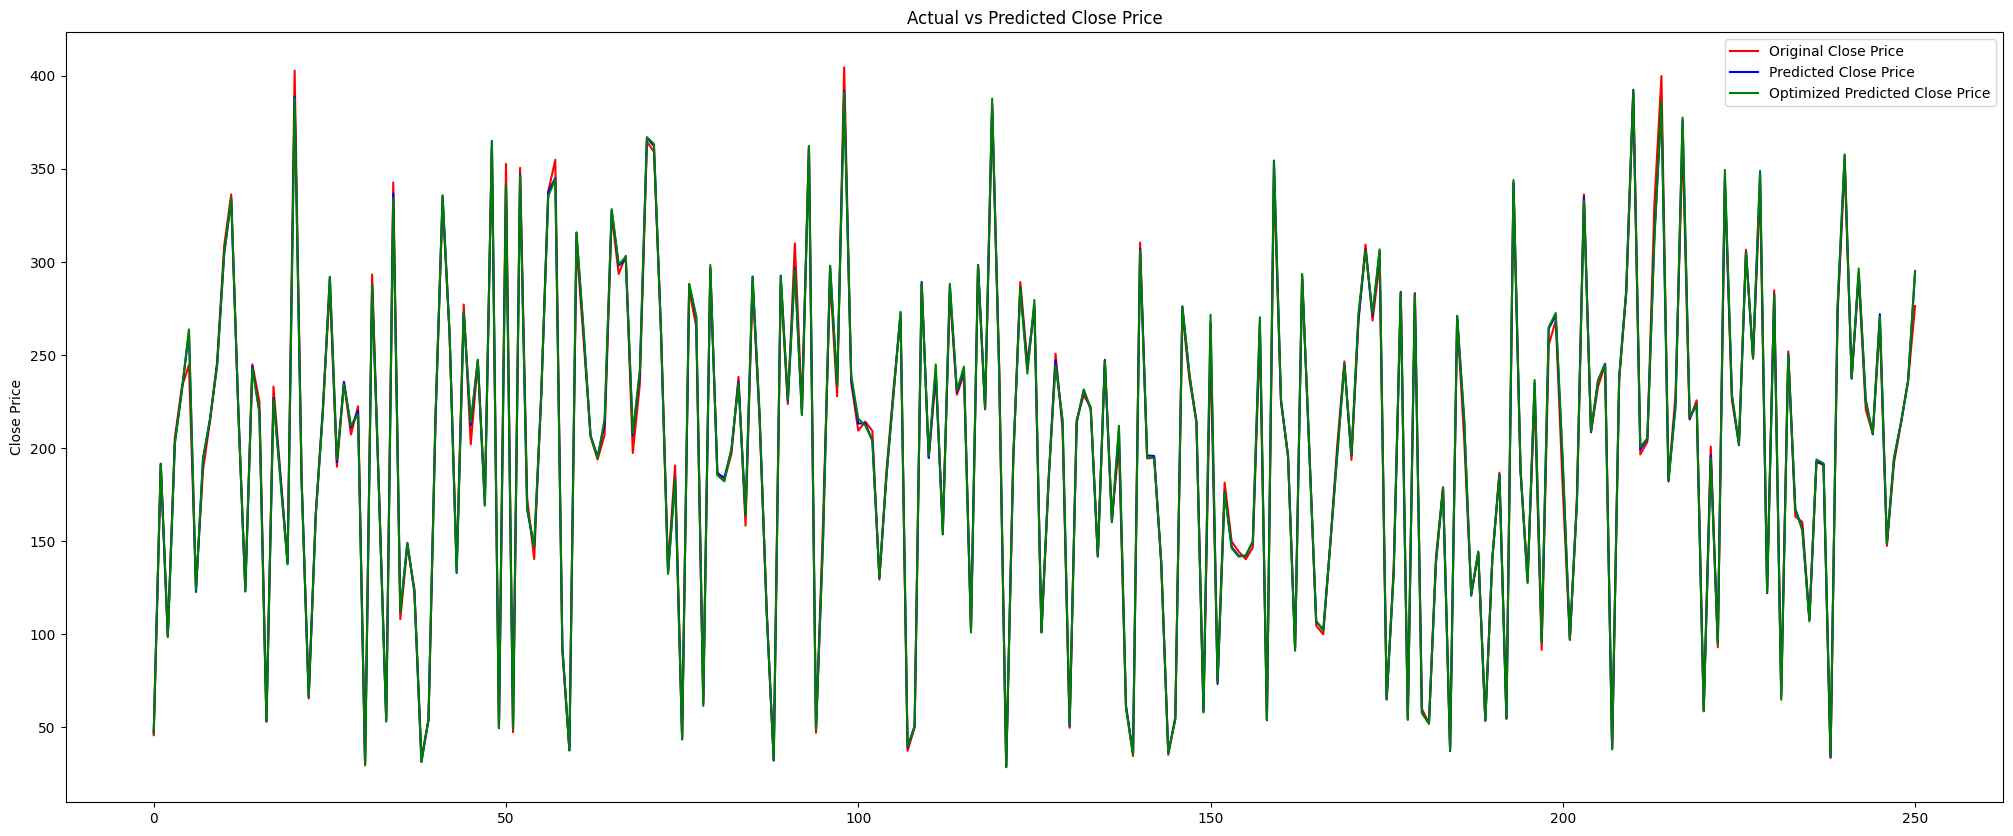

In [56]:
# Plot the line chart
plt.figure(figsize=(25, 10))

plt.plot(merged_df['Adj Close'], color= 'red', label='Original Close Price',)
plt.plot(merged_df['Predicted'], color='blue', label='Predicted Close Price')
plt.plot(merged_df['Optimized Predicted'], color='green', label='Optimized Predicted Close Price')

# Set the labels and title
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()